# GRN influence on velocity inference with RegVelo

Notebook infers velocity with RegVelo using different GRNs.

## Library imports

In [1]:
import pandas as pd
import torch
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import anndata as ad
import scvi
from cellrank.kernels import VelocityKernel
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import get_time_correlation, set_output
from rgv_tools.plotting import add_significance, get_significance

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda

## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

## Constants

In [3]:
DATASET = "cell_cycle"

In [4]:
significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}

In [5]:
STATE_TRANSITIONS = [("G1", "S"), ("S", "G2M")]

In [6]:
SAVE_DATA = True
SAVE_FIGURES = True

if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)
if SAVE_FIGURES:
    (FIG_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

## Data loading

In [7]:
adata = ad.io.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'true_skeleton'
    layers: 'Ms', 'Mu', 'spliced', 'total', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

## Model loading

In [8]:
vae = REGVELOVI.load(DATA_DIR / DATASET / "regvelo_model", adata)

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...


INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/cell_cycle/regvelo_model/model.pt already         
         downloaded                                                                                                


## Fix the learned GRN (30 times)

In [9]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")

In [ ]:
W = torch.ones((adata.n_vars, adata.n_vars), dtype=int)

score_v0 = []
score_t0 = []
for _ in range(30):
    vae_r = REGVELOVI(adata, W=W.T * 0, soft_constraint=False)
    vae_r.module.v_encoder.fc1.weight.data = vae.module.v_encoder.fc1.weight.data.detach().cpu().clone()
    vae_r.module.v_encoder.fc1.bias.data = vae.module.v_encoder.fc1.bias.data.detach().cpu().clone()
    vae_r.train()

    set_output(adata, vae_r, n_samples=30, batch_size=adata.n_obs)

    # Calculate CBC
    vk = VelocityKernel(adata).compute_transition_matrix()

    cluster_key = "phase"
    rep = "X_pca"

    score_df = []
    for source, target in STATE_TRANSITIONS:
        cbc = vk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

        score_df.append(
            pd.DataFrame(
                {
                    "State transition": [f"{source} - {target}"] * len(cbc),
                    "CBC": cbc,
                }
            )
        )
    score_df = pd.concat(score_df)

    score_v0.append(score_df["CBC"].mean())

    # Calculate latent time correlation
    score_t0.append(
        get_time_correlation(ground_truth=adata.obs["fucci_time"], estimated=adata.layers["fit_t"].mean(axis=1))
    )

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -887.862. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8588511535647391
0.4725250045208257


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -894.947. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8596672805867526
0.38710369176825343


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -938.565. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8564455649699128
0.3934783110568552


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -937.790. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8558641187477463
0.42529832578865945


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -861.957. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8621378117990315
0.49490148600428674


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -831.749. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8641103214915878
0.43082475668521414


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -868.171. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8578117031761111
0.4370804511182084


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -882.833. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8599962516604213
0.43689003613908556


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -858.975. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8577056986700093
0.5355623599908106


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -884.711. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8618184802704855
0.48137911728282035


## Randomly shuffled GRN

In [ ]:
dfs = []
score_v1 = []
score_t1 = []
for _ in range(30):
    original_tensor = vae.module.v_encoder.fc1.weight.data.detach().cpu().clone()
    original_shape = original_tensor.shape
    # Flatten the tensor
    flattened_tensor = original_tensor.flatten()
    # Generate a random permutation of indices
    permutation = torch.randperm(flattened_tensor.size(0))
    # Shuffle the flattened tensor using the permutation
    shuffled_flattened_tensor = flattened_tensor[permutation]

    permutation = torch.randperm(flattened_tensor.size(0))
    shuffled_flattened_tensor = shuffled_flattened_tensor[permutation]
    # Reshape the shuffled tensor back to the original shape
    shuffled_tensor = shuffled_flattened_tensor.reshape(original_shape)

    vae_r = REGVELOVI(adata, W=W.T * 0, soft_constraint=False)
    vae_r.module.v_encoder.fc1.weight.data = shuffled_tensor
    vae_r.module.v_encoder.fc1.bias.data = vae.module.v_encoder.fc1.bias.data.detach().cpu().clone()
    vae_r.train()

    set_output(adata, vae_r, n_samples=30, batch_size=adata.n_obs)

    # Calculate CBC
    vk = VelocityKernel(adata).compute_transition_matrix()

    cluster_key = "phase"
    rep = "X_pca"

    score_df = []
    for source, target in STATE_TRANSITIONS:
        cbc = vk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

        score_df.append(
            pd.DataFrame(
                {
                    "State transition": [f"{source} - {target}"] * len(cbc),
                    "CBC": cbc,
                }
            )
        )
    score_df = pd.concat(score_df)

    score_v1.append(score_df["CBC"].mean())

    # Calculate latent time correlation
    score_t1.append(
        get_time_correlation(ground_truth=adata.obs["fucci_time"], estimated=adata.layers["fit_t"].mean(axis=1))
    )

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -627.816. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8452725341719682
-0.014080427756811538


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -691.148. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8039583618570303
0.32394353044357516


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -565.537. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

0.8265581144574343
0.37640080971815765


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -630.118. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8385100476065661
0.33993372047815845


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -545.308. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

0.8261304052051127
-0.0015089014471513585


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -574.305. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8293143570431685
0.19300452004879504


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -613.091. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8189647643106012
-0.20952709404723668


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -608.745. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.7967200744462537
-0.07203070667011865


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -581.427. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

0.7922212944429371
-0.0619739656013155


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -632.080. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8367547233459951
0.2629577124547535


## Remove GRN

In [12]:
score_v2 = []
score_t2 = []
for _nrun in range(30):
    vae_r = REGVELOVI(adata, W=W.T * 0, soft_constraint=False)
    vae_r.module.v_encoder.fc1.weight.data = vae.module.v_encoder.fc1.weight.data.detach().cpu().clone() * 0
    vae_r.module.v_encoder.fc1.bias.data = vae.module.v_encoder.fc1.bias.data.detach().cpu().clone()
    vae_r.train()

    set_output(adata, vae_r, n_samples=30, batch_size=adata.n_obs)

    ## calculate CBC
    vk = VelocityKernel(adata).compute_transition_matrix()

    cluster_key = "phase"
    rep = "X_pca"

    score_df = []
    for source, target in STATE_TRANSITIONS:
        cbc = vk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

        score_df.append(
            pd.DataFrame(
                {
                    "State transition": [f"{source} - {target}"] * len(cbc),
                    "CBC": cbc,
                }
            )
        )
    score_df = pd.concat(score_df)

    score_v2.append(score_df["CBC"].mean())
    print(score_v2[len(score_v2) - 1])

    ## calculate latent time correlation
    score_t2.append(
        get_time_correlation(ground_truth=adata.obs["fucci_time"], estimated=adata.layers["fit_t"].mean(axis=1))
    )
    print(score_t2[len(score_t2) - 1])

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -735.155. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8109152083289309
0.13436847739033103


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -743.427. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8149304702171236
0.17193691118208765


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -763.882. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8138537622155599
0.1622874446377836


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -813.539. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8097353961139738
0.167300662606662


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -816.213. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8111166320540822
0.16675755382929097


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -846.872. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8087256263957093
0.1931690248935568


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -815.428. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8093981915485148
0.17033769863997297


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -827.179. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.812690718513738
0.14982405963390796


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -800.861. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8139056785735755
0.19820023385576366


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command 

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -779.785. Signaling Trainer to stop.


  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

0.8148896442860558
0.17471434468200486


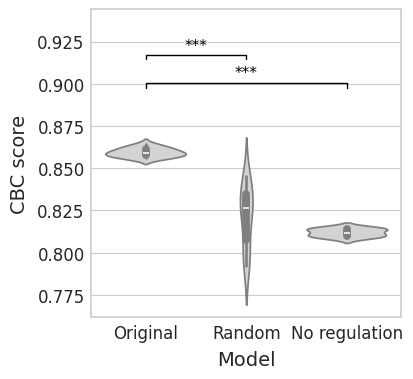

In [19]:
df = pd.DataFrame(
    {"CBC score": score_v0 + score_v1 + score_v2, "Model": ["Original"] * 30 + ["Random"] * 30 + ["No regulation"] * 30}
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.violinplot(data=df, x="Model", y="CBC score", ax=ax, color="lightgrey")

    ttest_res = ttest_ind(score_v0, score_v1, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(score_v0, score_v2, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.95)

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "CBC_score_GRN.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

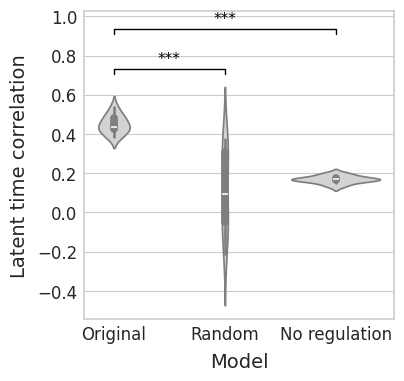

In [22]:
df = pd.DataFrame(
    {
        "Latent time correlation": score_t0 + score_t1 + score_t2,
        "Model": ["Original"] * 30 + ["Random"] * 30 + ["No regulation"] * 30,
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.violinplot(data=df, x="Model", y="Latent time correlation", ax=ax, color="lightgrey")

    ttest_res = ttest_ind(score_t0, score_t1, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(score_t0, score_t2, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.95)

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "Time_GRN.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()